In [1]:
%load_ext autoreload
%autoreload 1
%aimport Utils
%aimport MatrixLinkGenerator
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
# np.set_printoptions(linewidth=np.inf)
from obspy import UTCDateTime
import json
import matplotlib.pyplot as plt
from Utils import trainingResults, trainingResults2, predsMap
# plt.rcParams['figure.figsize'] = [50, 200]
plt.rcParams['figure.figsize'] = [16, 12]
params = json.loads('''{
    "extents": {
        "s1": {
            "latMin": 22.0,
            "latMax": 40.0,
            "lonMin": 33.0,
            "lonMax": 62.0
        }
    },
    "location": "s1",
    "maxDepth": 50.0,
    "maxStationElevation": 0.5,
    "trainingGeneratorSourceFile": "./Training/Inputs/S1 00.gz",
    "trainingEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3+ Arrivals 120 TimeNorm.npz",
    "validationGeneratorSourceFile": "./Inputs/S1 00.gz",
    "validationEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3+ Arrivals 120 TimeNorm.npz",
    "arrivalProbsFile": "./Training/RSTT Model/S1 Dropouts.npy",
    "arrivalProbMods": {
        "Pg": 7.0,
        "Pn": 4.5,
        "Sg": 7.0,
        "Sn": 25.0
    },
    "eventsPerExample": {
        "min": 1,
        "max": 4
    },
    "stationsPerBatch": {
        "min": 45,
        "max": 55
    },
    "timeShifts": {
        "min": -0.50,
        "max": 0.50
    },
    "batchSize": 1000,
    "samplesPerEpoch": 1000000,
    "validationSamplesPerEpoch": 250000,
    "epochs": 500,
    "model": "./Models/Batch Error E076 L0.0965 A0.9725 P0.9514 R0.9573 HL81.4 VL0.0339 VA0.9807 VP0.9736 VR0.9796 VHL75.6.h5",
    "evalInFile": "./Inputs/S1 00.gz",
    "evalOutFile": "./Training/Evaluation.gz",
    "prlEvalOutFile": "./Training/PRL Evaluation.gz",
    "maxArrivals": 50,
    "minArrivals": 5,
    "maxNoise": 0.25,
    "clusterStrength": 0.9,
    "timeNormalize": 120,
    "associationWindow": 300,
    "evalWindow": 10.0,
    "phases": {
        "Pg": 0, "PcP": 0, "Pb": 0,
        "P": 1, "Pn": 1,
        "S": 2, "Sg": 2, "ScP": 2, "Lg": 2, "Sb": 2,
        "Sn": 3
    },
    "modelArch": {
        "dense": [32, 32, 64, 128, 128],
        "transformers": [256, 256],
        "heads": 4,
        "dense2": [128, 128, 128],
        "grus": [256, 256]
    }
}''')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#MatrixLinkTrainer
import tensorflow as tf
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Embedding, Reshape, concatenate, Dense, Bidirectional, GRU, MultiHeadAttention, LayerNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import logging
import json
from MatrixLinkGenerator import generateEventFile, synthesizeEvents, synthesizeEventsFromEventFile
from Utils import nzBCE, nzMSE, nzPrecision, nzRecall, nzHaversine, trainingResults

@tf.autograph.experimental.do_not_convert
def MatrixLink(params):
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    def buildModel(modelArch):
        outputs = []
        inputs = []
        numericalInputs = Input(shape=(None,4), name='numerical_features')
        outputs.append(numericalInputs)
        inputs.append(numericalInputs)
        categoricalInputs = Input(shape=(None,1), name='phase')
        embed = Embedding(5, 2, trainable=True, embeddings_initializer=RandomNormal())(categoricalInputs)
        embed = Reshape(target_shape=(-1,2))(embed)
        outputs.append(embed)
        inputs.append(categoricalInputs)
        outputs = concatenate(outputs)

        def TransformerBlock(inputs, embed_dim, ff_dim, num_heads=2, rate=0.1, eps=1e-6):
            attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
#             attn_output = Dropout(rate)(attn_output)
            out1 = LayerNormalization(epsilon=eps)(inputs + attn_output)
            ffn_output = Dense(ff_dim, activation="relu")(out1)
            ffn_output = Dense(embed_dim)(ffn_output)
#             ffn_output = Dropout(rate)(ffn_output)
            return LayerNormalization(epsilon=eps)(out1 + ffn_output) 

        for d1Units in modelArch['dense']:
            outputs = Dense(units=d1Units, activation=tf.nn.relu)(outputs)
        transformerOutputs = outputs
        gruOutputs = outputs

        for tUnits in modelArch['transformers']:
            transformerOutputs = TransformerBlock(transformerOutputs, d1Units, tUnits, modelArch['heads'])
        for gUnits in modelArch['grus']:
            gruOutputs = Bidirectional(GRU(gUnits, return_sequences=True))(gruOutputs)

        outputs = concatenate([transformerOutputs, gruOutputs], axis=2)
        for tUnits in modelArch['transformers']:
            outputs = TransformerBlock(outputs, d1Units+gUnits*2, tUnits, modelArch['heads'])

        association = Dense(units=params['maxArrivals'], activation=tf.nn.sigmoid, name='association')(outputs)
        location = Dense(units=2, name='location')(outputs)
        noise = Dense(units=1, activation=tf.nn.sigmoid, name='noise')(outputs)
        
        model = Model(inputs=inputs, outputs=[association, location, noise])
        losses = { 'association': nzBCE, 'location': nzMSE, 'noise': nzBCE }
        weights = { 'association': 1.0, 'location': 10.0, 'noise': 0.5 }
        metrics = { 'association': [nzPrecision, nzRecall],
                    'location': nzHaversine,
                    'noise': [nzPrecision, nzRecall]
                  }
        model.compile(optimizer=Adam(clipnorm=0.00001), loss=losses, loss_weights=weights, metrics=metrics)
        return model

    model = buildModel(params['modelArch'])
    try:
        model.load_weights(params['model'])
        print("Loaded previous weights.")
    except Exception as e:
        print(e)
        print("No previous weights loaded.")
    print(model.summary())
    return model

class saveCb(Callback):
    def on_train_begin(self, logs=None):
        self.best = 100.
    def on_epoch_end(self, epoch, logs=None):
        if logs['loss'] < self.best:
            self.best = logs['loss']
            print('Saving best model with loss', self.best)
#             modelName = 'E%03d L%.4f A%.4f P%.4f R%.4f HL%.1f VL%.4f VA%.4f VP%.4f VR%.4f VHL%.1f.h5' %\
#                 (epoch, logs['loss'], logs['association_nzAccuracy'], logs['association_precision'], logs['association_recall'], logs['location_nzHaversine'], 
#                  logs['val_loss'], logs['val_association_nzAccuracy'], logs['val_association_precision'], logs['val_association_recall'], logs['val_location_nzHaversine'])
            modelName = 'E%03d L%.4f AL%.4f NL%.4f LL%.4f AP%.4f AR%.4f NP%.4f NR%.4f HL%.1f.h5' %\
                (epoch, logs['loss'], logs['association_loss'], logs['noise_loss'], logs['location_loss'], logs['association_nzPrecision'], logs['association_nzRecall'], logs['noise_nzPrecision'], logs['noise_nzRecall'], logs['location_nzHaversine'])
            model.save("./Training/Models/"+modelName)

In [ ]:
# tf.config.threading.set_intra_op_parallelism_threads(2)
# tf.config.threading.set_inter_op_parallelism_threads(2)

# trainingEvents, trainingEventList = generateEventFile(params, trainingSet=True)
# validationEvents, validationEventList = generateEventFile(params)

# generator = synthesizeEventsFromEventFile(params, trainingEvents, trainingEventList, trainingSet=True)
generator = synthesizeEvents(params)
# vgen = synthesizeEventsFromEventFile(params, validationEvents, validationEventList)
# vgen = synthesizeEvents(params)

model = MatrixLink(params)
history = model.fit(generator,
#                  validation_data=vgen,
                 steps_per_epoch= params['samplesPerEpoch']/params['batchSize'],
#                  validation_steps = params['validationSamplesPerEpoch']/params['batchSize'],
                 epochs=params['epochs'],
                 callbacks=[saveCb(), EarlyStopping(monitor='loss', patience=40), CSVLogger('./Training/Models/logs.csv', append = True)],
                 verbose=1)
# trainingResults2(np.genfromtxt('./Training/Models/logs.csv', delimiter=',', names=True))

Reading input file... 204550 arrivals found
Creating permutations... 58 74 83 65 69 57 61 65 57 56 80 57 53 58 55 70 74 65 54 79 53 67 72 79 57 70 68 55 53 65 71 76 60 56 52 75 77 82 58 63 56 52 56 54 56 51 51 64 66 72 71 61 63 63 54 52 56 59 76 55 66 55 77 61 63 60 53 74 62 62 52 59 54 62 54 62 making initial predictions... clustering and building events...
Creating event 27650
Matching event 22463 / 22463        
Evaluating event 22463 / 22463        
-----------------------------
IoU evaluation for events with at least 5 arrivals for model ./Models/Batch Error E076 L0.0965 A0.9725 P0.9514 R0.9573 HL81.4 VL0.0339 VA0.9807 VP0.9736 VR0.9796 VHL75.6.h5
Parameters - evalInFile: ./Inputs/S1 00.gz	 maxArrivals: 50	 associationWindow: 300	 clusterStrength: 0.9
Totals/Average IoU: 184387 / 185350 = 0.9948044240625843
Precision: 1.0
Recall: 0.9948044240625843
F1: 0.9973954459521227
Fake Arrivals: 0 / 0
Created / Actual Events: 22463 / 22463
Missed Events: 0
Merged Events: 0
Fake Events: 0
Ar

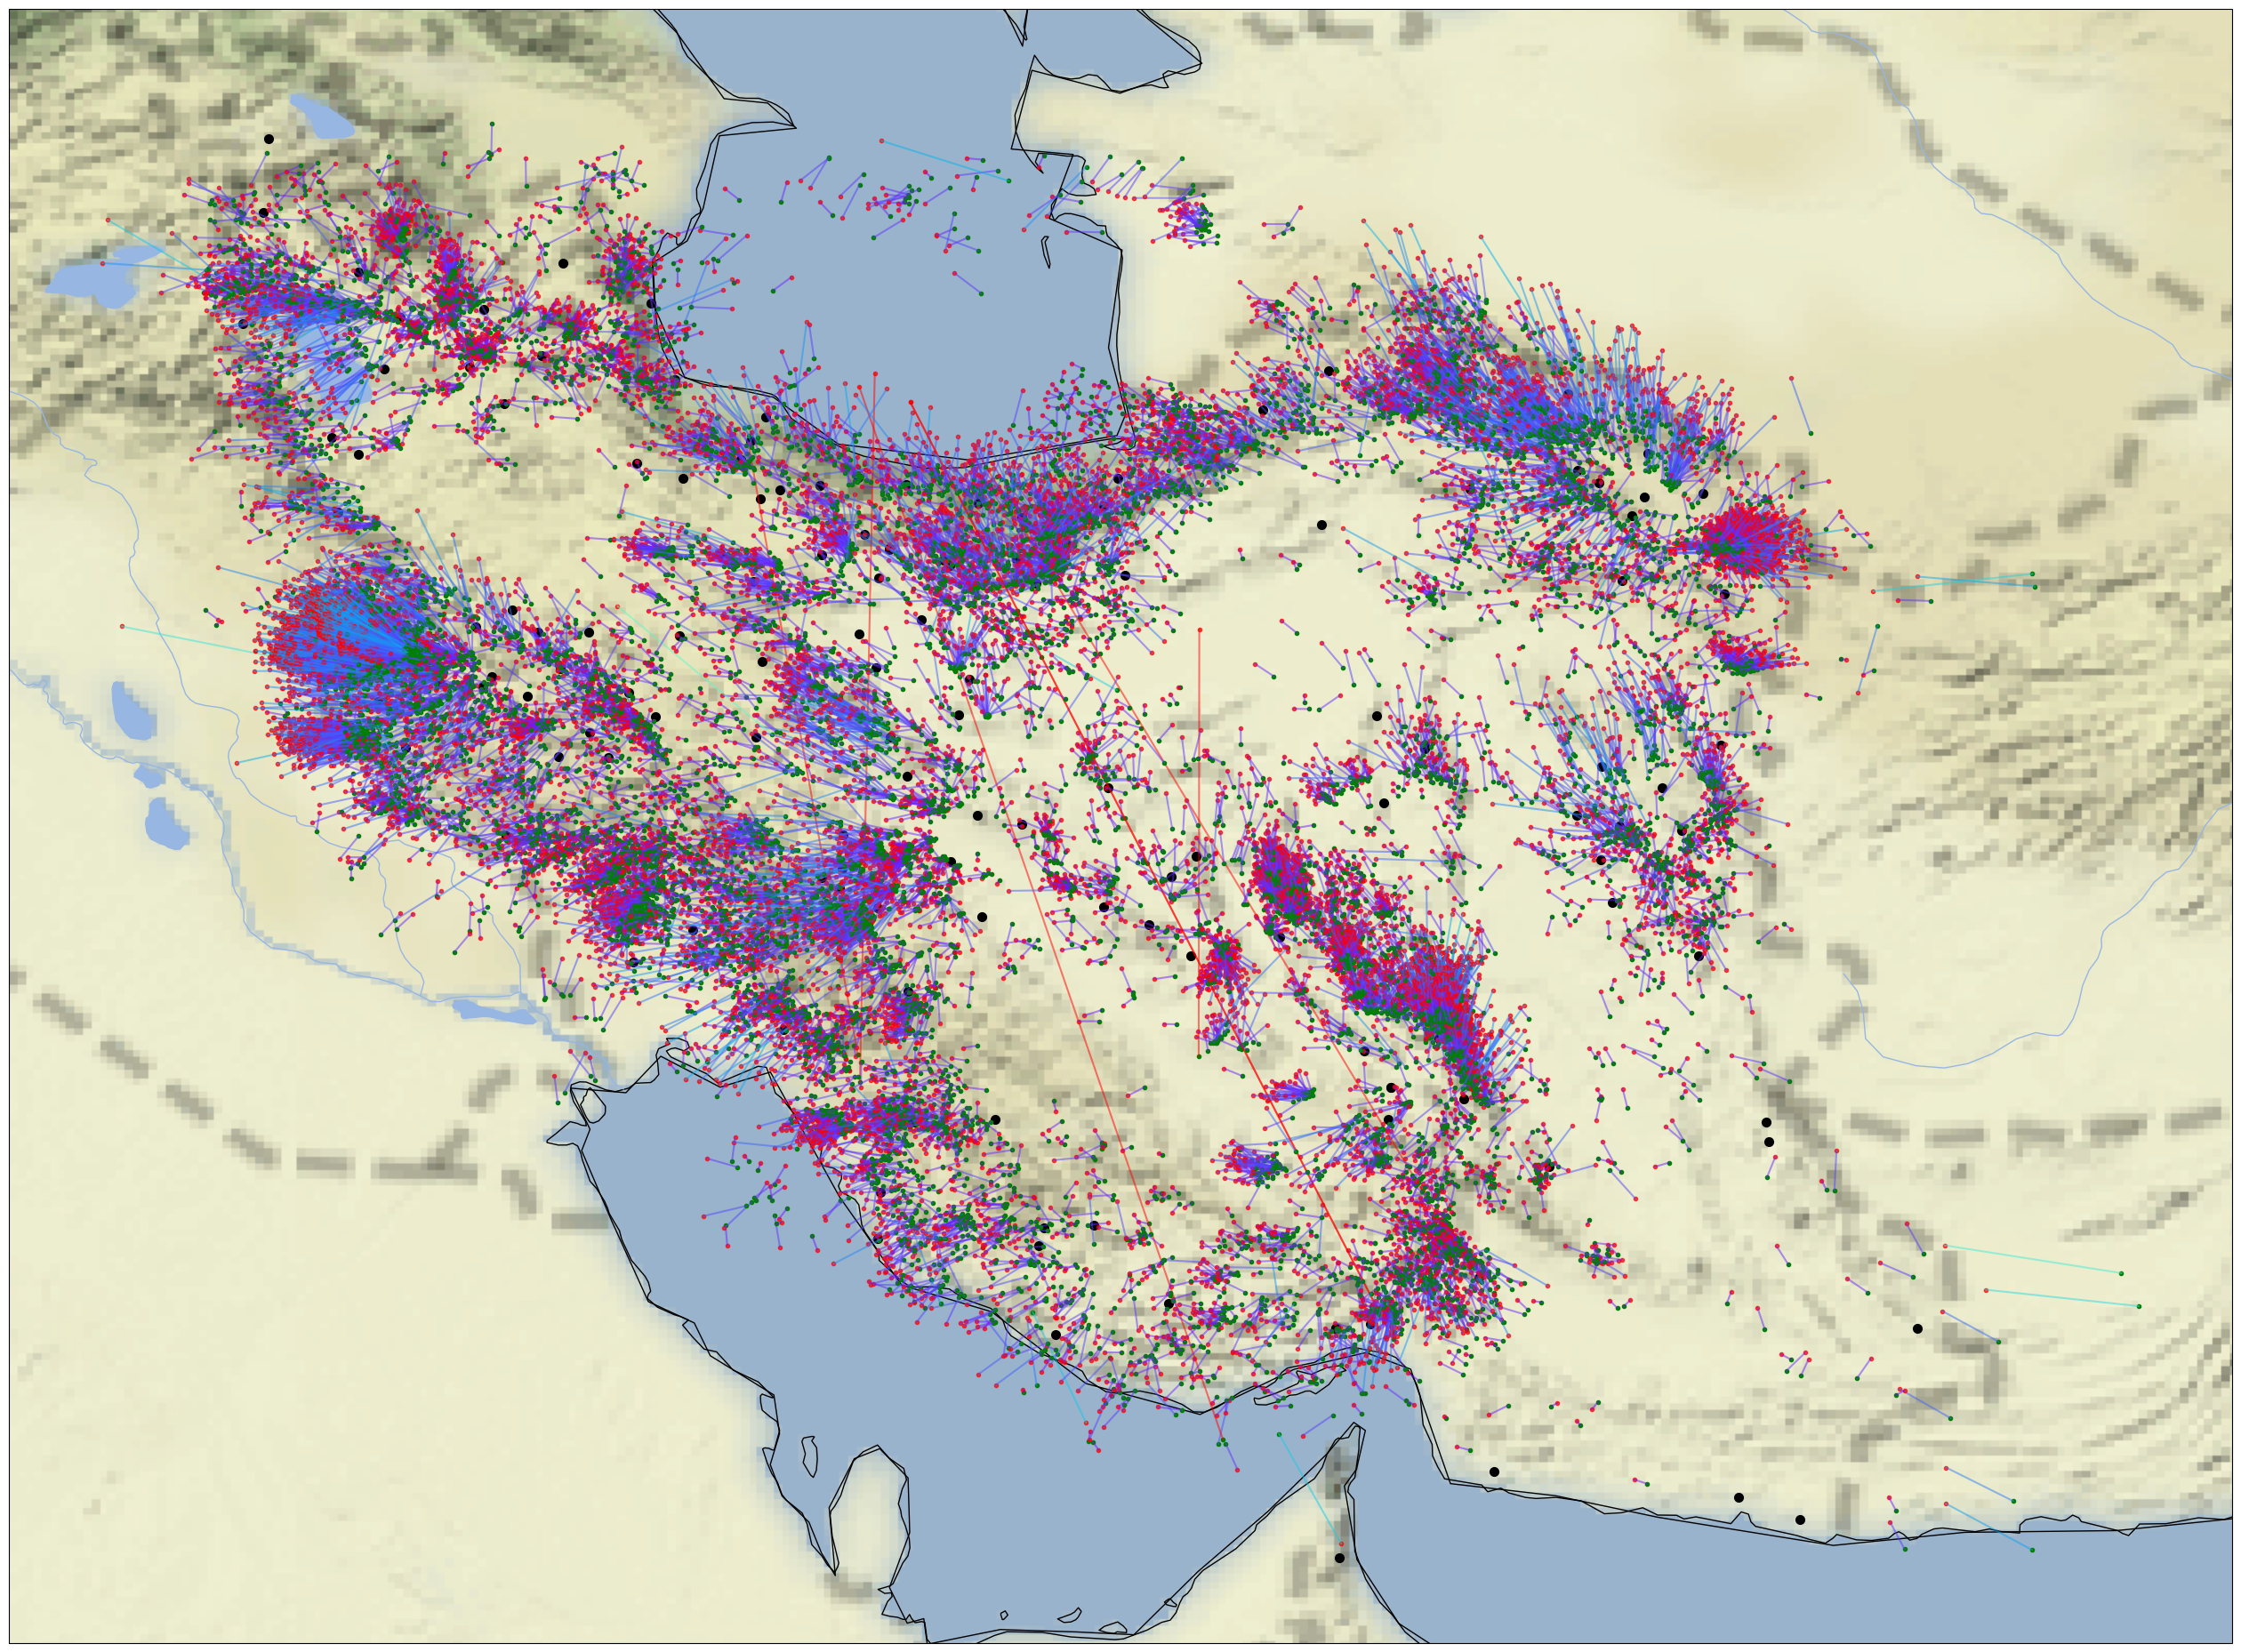

-----------------------------
Consolidated summary for: ./Models/Batch Error E076 L0.0965 A0.9725 P0.9514 R0.9573 HL81.4 VL0.0339 VA0.9807 VP0.9736 VR0.9796 VHL75.6.h5
File	AHM	 Location
00    99.22    32.16


In [2]:
#MatrixLink
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from collections import deque
from math import ceil
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow.keras.models import load_model
from obspy import UTCDateTime
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import squareform
from Utils import nzBCE, nzMSE, nzMSE2, nzHaversine, nzPrecision, nzRecall, nzAccuracy, evaluate

# Build permutation lists and matrices to predict on
def permute(X):
    outerWindow = params['associationWindow']
    minArrivals = params['minArrivals']
    maxArrivals = params['maxArrivals']
    X_perm = deque()
    for _, arrivals in labels.reset_index(drop=True).groupby('EVID'):
        X_perm.append(arrivals.index[:maxArrivals])
        if len(arrivals.index) > maxArrivals:
            print(len(arrivals.index), end=' ')
    X_test = np.zeros((len(X_perm),maxArrivals,5))
    for i in range(len(X_perm)):
        X_test[i,:len(X_perm[i])] = X[X_perm[i]]
        X_test[i,:len(X_perm[i]),2] -= X_test[i,0,2]
    X_test[:,:,2] /= params['timeNormalize']
    return X_perm, X_test

def buildEvents(X, labels, X_perm, X_test, Y_pred):
    minArrivals = params['minArrivals']
    timeNormalize = params['timeNormalize']
    catalogue = pd.DataFrame(columns=labels.columns)
    evid = 1
    for ev in range(len(X_perm)):
        eventIdx = X_perm[ev]
        candidate = labels.iloc[eventIdx].copy()
        candidate['PLAT'] = Y_pred[1][ev][:len(eventIdx)][:,0]*latRange+extents[0]
        candidate['PLON'] = Y_pred[1][ev][:len(eventIdx)][:,1]*lonRange+extents[2]
        candidate['LAT'] = np.median(candidate.PLAT)
        candidate['LON'] = np.median(candidate.PLON)
        print("\rCreating event " + str(evid), end='')
        candidate.EVID = evid
        catalogue = catalogue.append(candidate)
        evid += 1
    catalogue = catalogue[catalogue.ORID != -1].groupby('EVID').filter(lambda x: len(x) >= minArrivals)
    print()
    return catalogue

def matrixLink(X, labels):
    print("Creating permutations... ", end='')
    X_perm, X_test = permute(X)
    print("making initial predictions... ", end='')
    Y_pred = model.predict({"phase": X_test[:,:,3], "numerical_features": X_test[:,:,[0,1,2,4]]})
    print("clustering and building events...")
    catalogue = buildEvents(X, labels, X_perm, X_test, Y_pred)
    return catalogue

def processInput():
    print("Reading input file... ", end='')
    X = []
    labels = []
    for i, r in inputs.iterrows(): # I can do this better
        phase = r.PHASE
        time = UTCDateTime(r.TIME)
        lat = abs((r.ST_LAT - extents[0]) / latRange)
        lon = abs((r.ST_LON - extents[2]) / lonRange)
        otime = time - UTCDateTime(0)
        try:
            arrival = [lat, lon, otime, phases[phase], 1]
            X.append(arrival)
            labels.append(r)
        except Exception as e:
            print(e)
    X = np.array(X)
    idx = np.argsort(X[:,2])
    X = X[idx,:]
    X[:,2] -= X[0,2]
    labels = pd.DataFrame([labels[i] for i in idx])
    print("%d arrivals found" % len(labels))
    return X, labels

if __name__ == "__main__":
    pd.options.display.float_format = "{:.2f}".format
#     with open("Parameters.json", "r") as f:
#         params = json.load(f)
    phases = params['phases']
    extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
    latRange = abs(extents[1] - extents[0])
    lonRange = abs(extents[3] - extents[2])
    model = load_model(params['model'], custom_objects={'nzBCE':nzBCE, 'nzMSE':nzMSE, 'nzMSE2':nzMSE2, 'nzHaversine':nzHaversine, 'nzPrecision':nzPrecision, 'nzRecall':nzRecall, 'nzAccuracy':nzAccuracy}, compile=True)

#     inFiles = ['./Inputs/S1 50.gz', './Inputs/S1 25.gz', './Inputs/S1 15.gz', './Inputs/S1 00.gz']
    inFiles = ['./Inputs/S1 00.gz']
    evals = {file:[] for file in inFiles}
    for i in range(len(inFiles)):
        inputs = pd.read_pickle(inFiles[i]).sort_values(by=['TIME']).reset_index(drop=True)
        params['evalInFile'] = inFiles[i]
#         start = inputs[inputs.TIME >= inputs.TIME.quantile(.8)].index[0]
#         end = inputs[inputs.TIME >= inputs.TIME.quantile(.825)].index[0]
#         inputs = inputs[start:end]

        X, labels = processInput()
        outputs = matrixLink(X, labels)
        outputs.to_pickle(params['evalOutFile'])
        evals[inFiles[i]] = evaluate(params, inputs, outputs, verbose=False)

    print("Consolidated summary for:", params['model'])
    print('File\tAHM\t Location')
    for file in evals.keys():
        print(file[-5:-3], "{:8.2f}".format(evals[file][0]), "{:8.2f}".format(evals[file][1]))